In [1]:
# import libraries

import math 
import datetime
import traceback
from sqlalchemy import create_engine,text
import pymysql

import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree

from sklearn.ensemble import RandomForestClassifier

import xgboost as Xgb

from sklearn.svm import SVC

In [2]:
class Electric_Fault_Prediction:
    def __init__(self):
        self.data = None
        self.engine = None

    def createlogfile(self):
        try:
            fname = "EFP_Logfile"
            time = datetime.datetime.now()
            tm = time.strftime("%m-%d-%Y-%H-%M-%S")
            self.file_name = fname + '_' + str(tm) + '.txt'
            with open(self.file_name, 'a') as f:
                f.write('INFO : Log File Created\n')
        except Exception:
            return False, 'ERROR: Exception Occurred, Log File Not Created\n'+traceback.format_exc()           
        return True, 'INFO: Log File Created Successfully\n'

    
    def connection(self):
        try:
            username = 'root'
            password = '9175033081'
            host = 'localhost:3306'
            database = 'abhidb'
            self.engine = create_engine("mysql+pymysql://" + username + ":" + password + "@" + host + "/" + database)
        except Exception:
            return False, 'Error: Exception Occured, Log File Not Created\n' + traceback.format_exc()
        return True, 'INFO : Connection Created Successfully ! \n'

    
    def display_all_data(self):
        desired_width = 370
        pd.set_option('display.width',desired_width)
        pd.set_option('display.max_columns',28)

    
    def data_load_to_database(self):
        try:
            self.data = pd.read_csv("classData.csv")
            print("Data load to Database--------------------------------------------------------------!\n")
            with self.engine.begin() as conn:
                self.data.to_sql(con=conn , name='classdata', if_exists='replace', index=False)
                print("Data loading successfully----------------------------------------------------------!\n")
                # print(self.data)

        except Exception:
            return False,'Error:Data Not Loaded to Database \n' + traceback.format_exc()
        return True,'INFO : Data loading to Database Successfully ! \n'  
            

    def print_data(self):
        try:
            print("Data printing started--------------------------------------------------------------!\n ")
            with self.engine.begin() as conn:
                query = text("SELECT * FROM classData")
                self.data = pd.read_sql_query(query, conn)
                print(self.data)           
            print("Data Print Completed---------------------------------------------------------------!\n")
        except Exception:
            return False, None, 'Error : Data Printing Error\n' + traceback.format_exc()
        return True, self.data,'INFO : Data Printing Successfully !\n'

    
    def check_data(self):
        try:           
            self.data.sample(7)
            self.data.info()
            self.data.isnull().sum()
            self.data.shape
            self.data.describe()
            self.data.duplicated().sum()
            self.data.columns
    
            # list of numerical variables
            numerical_features = [feature for feature in self.data.columns if self.data[feature].dtypes != 'O']
            print('Number of numerical_features :', len(numerical_features))
            print('Printing numerical_features data....................................!')
            print(self.data[numerical_features].head())
    
            # finding discrete variable 
            global discrete_feature
            discrete_feature = [feature for feature in numerical_features if len(self.data[feature].unique())<10]
            print("discrete_feature Count: {}".format(len(discrete_feature)))
            print('Printing discrete_feature data....................................!')
            print(self.data[discrete_feature].head())
    
            # finding Continous variable 
            global continuous_feature
            continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature]
            print("continuous_feature count {}".format(len(continuous_feature)))     
            print('Printing continuous_feature data....................................!')
            print(self.data[continuous_feature].head())
    
            # Finding Categorical
            categorical_features=[feature for feature in self.data.columns if self.data[feature].dtypes=='O']
            print("categorical_features count {}".format(len(categorical_features)))
            print('Printing categorical_features data....................................!')
            print(self.data[categorical_features].head())   

            # univariate_analysis
            print('!!...Started Univariate Analysis of Discrete Variable ...!!')
            for feature in discrete_feature:
                data=self.data.copy()
                data[feature].hist(bins=25)
                plt.xlabel(feature)
                plt.ylabel('count')
                plt.show()

                sns.kdeplot(data[feature], fill=True, bw_method=5)
                plt.title('kdeplot of {}'.format(feature))
                plt.xlabel(feature)
                plt.ylabel('Probability of Density')
                plt.show()
            print('!!...End of Univariate Analysis of Discrete Variable ...!!') 

            print('*'*100)
        
            print('!!...Started Univariate Analysis of Continuous Variable ...!!')
            for feature in continuous_feature:
                data=self.data.copy()
                data[feature].hist(bins=25)
                plt.xlabel(feature)
                plt.ylabel('count')
                plt.show()

                sns.kdeplot(data[feature], fill=True, bw_method=5)
                plt.title('kdeplot of {}'.format(feature))
                plt.xlabel(feature)
                plt.ylabel('Probability of Density')
                plt.show()
            print('!!...End of Univariate Analysis of Continuous Variable ...!!')

            # outliers_checking
            print('!!...Started Boxplot for Outliers Checking ...!!')
            for feature in self.data.columns:
                data=self.data.copy()
                data.boxplot(column=feature) # boxplot only with continuous variables not for catagorical
                plt.ylabel(feature)
                plt.title(feature)
                plt.show()
            print('!!...End of Boxplot for Outliers Checking ...!!')

            print('!!...Summery of Outliers Checking ...!!')
            col = self.data.columns
            outliers_bucket = self.data.boxplot()

            # Multivariate Analysis
            print('!!...Started Multivariate Analysis ...!!')
            print(self.data.corr())
            plt.figure(figsize=(15,7))
            # sns.heatmap(self.data.corr(),annot=True)
            # sns.pairplot(self.data)
            print('!!...End of Multivariate Analysis ...!!')

        except Exception:
            return False,'Error : Data Checking Error\n' + traceback.format_exc()
        
        return True,'INFO : Data Check Successfully !\n'

    
    def feature_engineering(self):
        # [0 0 0 0] - No Fault
        # [1 0 0 0] - Ground Fault
        # [0 0 0 1] - Fault in Line A
        # [0 0 1 0] - Fault in Line B
        # [0 1 0 0] - Fault in Line C
        # [1 0 0 1] - LG fault (Between Phase A and Ground)
        # [1 0 1 0] - LG fault (Between Phase B and Ground)
        # [1 1 0 0] - LG fault (Between Phase C and Ground)
        # [0 0 1 1] - LL fault (Between Phase B and Phase A)
        # [0 1 1 0] - LL fault (Between Phase C and Phase B)
        # [0 1 0 1] - LL fault (Between Phase C and Phase A)
        # [1 1 0 0] - LG fault (Between Phase C and Ground)
        # [1 0 1 0] - LG fault (Between Phase B and Ground)
        # [1 0 0 1] - LG fault (Between Phase A and Ground)
        # [1 0 1 1] - LLG Fault (Between Phases A,B and Ground)
        # [1 1 0 1] - LLG Fault (Between Phases A,C and Ground)
        # [1 1 1 0] - LLG Fault (Between Phases C,B and Ground)
        # [0 1 1 1] - LLL Fault(Between all three phases)
        # [1 1 1 1] - LLLG fault( Three phase symmetrical fault)
        # we need to add column "fault type" in our dataframe
        try:
            self.data['Fault_Type']=self.data['G'].astype('str') + self.data['C'].astype('str') + self.data['B'].astype('str') + self.data['A'].astype('str')
            print(self.data)
            print(self.data['Fault_Type'].unique())
            
            # Giving the proper name to the fault according to the data description provided above

            # self.data['Fault_Type'][self.data['Fault_Type'] == '0000' ] = 'NO Fault'
            # self.data['Fault_Type'][self.data['Fault_Type'] == '1001' ] = 'Line A to Ground Fault'
            # self.data['Fault_Type'][self.data['Fault_Type'] == '0110' ] = 'Line B to Line C Fault'
            # self.data['Fault_Type'][self.data['Fault_Type'] == '1011' ] = 'Line A Line B to Ground Fault'
            # self.data['Fault_Type'][self.data['Fault_Type'] == '0111' ] = 'Line A Line B Line C'
            # self.data['Fault_Type'][self.data['Fault_Type'] == '1111' ] = 'Line A Line B Line C to Ground Fault'

            self.data.loc[self.data['Fault_Type'] == '0000' , 'Fault_Type'] = 'NO Fault'
            self.data.loc[self.data['Fault_Type'] == '1001' , 'Fault_Type'] = 'Line A to Ground Fault'
            self.data.loc[self.data['Fault_Type'] == '0110' , 'Fault_Type'] = 'Line B to Line C Fault'
            self.data.loc[self.data['Fault_Type'] == '1011' , 'Fault_Type'] = 'Line A Line B to Ground Fault'
            self.data.loc[self.data['Fault_Type'] == '0111' , 'Fault_Type'] = 'Line A Line B Line C'
            self.data.loc[self.data['Fault_Type'] == '1111' , 'Fault_Type'] = 'Line A Line B Line C to Ground Fault'

            print(self.data['Fault_Type'].value_counts(ascending=False))

            ax = sns.countplot(x='Fault_Type', data=self.data)
            ax.bar_label(ax.containers[0])
            plt.xticks(rotation=65)

            self.data['Fault_Type'].value_counts().plot.pie(autopct='%1.2f%%')

            plt.figure(figsize = (10,4))
            plt.plot(self.data["Ia"])
            plt.plot(self.data["Ib"])
            plt.plot(self.data["Ic"]);

            plt.figure(figsize = (10,4))
            plt.plot(self.data["Va"])
            plt.plot(self.data["Vb"])
            plt.plot(self.data["Vc"]);

            print('Voltage or Current graph, where there is large fluctuation in the graph, there faults have occurred')
            
            plt.plot(self.data['Fault_Type'])

            # Separating Faults into different Categories
            
            print('!!...Separating Faults into different Categories...!!')
            print('1. No Fault (Healthy System)')
            No_Fault = self.data[self.data['Fault_Type'] == 'NO Fault' ]
            ax = plt.figure(figsize = (18,3))
            ax = plt.plot(No_Fault["Ia"],'r')
            ax = plt.plot(No_Fault["Ib"],'b')
            ax = plt.plot(No_Fault["Ic"],'g');
            plt.figure(figsize = (18,3))
            plt.plot(No_Fault[["Ic","Ib","Ia"]]);
            ax = plt.figure(figsize = (18,3))
            ax = plt.plot(No_Fault["Va"],'r')
            ax = plt.plot(No_Fault["Vb"],'b')
            ax = plt.plot(No_Fault["Vc"],'g');

            print('In a normal (No_Fault) condition Voltage or Current graph, is symmetrical and sinusoidal in nature with current and voltage 120 degree in phase shift and maximum current is approximately +100 to -100 Amperes and voltage +0.5 pu to -0.5pu')
            
            print('2. Faulty System with Line A to Ground Fault')
            Line_AG_Fault = self.data[self.data['Fault_Type'] == 'Line A to Ground Fault' ]
            ax = plt.figure(figsize = (18,3))
            ax = plt.plot(Line_AG_Fault["Ia"],'r')
            ax = plt.plot(Line_AG_Fault["Ib"],'b')
            ax = plt.plot(Line_AG_Fault["Ic"],'g');
            ax = plt.figure(figsize = (18,3))
            ax = plt.plot(Line_AG_Fault["Va"],'r')
            ax = plt.plot(Line_AG_Fault["Vb"],'b')
            ax = plt.plot(Line_AG_Fault["Vc"],'g');
            print('At a time of Line A to grounf fault the current in line A increases to 10 fold approximately 1000 Ampears form normal 100 Ampears and voltage reduced.')
            
            print('3. Faulty System with Line A ,Line B to Ground Fault')
            Line_ABG_Fault = self.data[self.data['Fault_Type'] == 'Line A Line B to Ground Fault' ]
            ax = plt.figure(figsize = (18,3))
            ax = plt.plot(Line_ABG_Fault["Ia"],'r')
            ax = plt.plot(Line_ABG_Fault["Ib"],'b')
            ax = plt.plot(Line_ABG_Fault["Ic"],'g');
            ax = plt.figure(figsize = (18,3))
            ax = plt.plot(Line_ABG_Fault["Va"],'r')
            ax = plt.plot(Line_ABG_Fault["Vb"],'b')
            ax = plt.plot(Line_ABG_Fault["Vc"],'g');

            print('4. Faulty System with Line B to Line C')
            Line_BC_Fault = self.data[self.data['Fault_Type'] == 'Line B to Line C Fault' ]        
            ax = plt.figure(figsize = (18,3))
            ax = plt.plot(Line_BC_Fault["Ia"],'r')
            ax = plt.plot(Line_BC_Fault["Ib"],'b')
            ax = plt.plot(Line_BC_Fault["Ic"],'g');
            ax = plt.figure(figsize = (18,3))
            ax = plt.plot(Line_BC_Fault["Va"],'r')
            ax = plt.plot(Line_BC_Fault["Vb"],'b')
            ax = plt.plot(Line_BC_Fault["Vc"],'g');

            print('5. Faulty System with Line A - Line B - Line C')
            Line_ABC_Fault = self.data[self.data['Fault_Type'] == 'Line A Line B Line C' ]
            ax = plt.figure(figsize = (18,3))
            ax = plt.plot(Line_ABC_Fault["Ia"],'r')
            ax = plt.plot(Line_ABC_Fault["Ib"],'b')
            ax = plt.plot(Line_ABC_Fault["Ic"],'g');       
            ax = plt.figure(figsize = (18,3))
            ax = plt.plot(Line_ABC_Fault["Va"],'r')
            ax = plt.plot(Line_ABC_Fault["Vb"],'b')
            ax = plt.plot(Line_ABC_Fault["Vc"],'g');
            
            print('6. Faulty System with Line A - Line B - Line C - Ground')
            Line_ABCG_Fault = self.data[self.data['Fault_Type'] == 'Line A Line B Line C to Ground Fault' ]
            ax = plt.figure(figsize = (18,3))
            ax = plt.plot(Line_ABCG_Fault["Ia"],'r')
            ax = plt.plot(Line_ABCG_Fault["Ib"],'b')
            ax = plt.plot(Line_ABCG_Fault["Ic"],'g');
            ax = plt.figure(figsize = (18,3))
            ax = plt.plot(Line_ABCG_Fault["Va"],'r')
            ax = plt.plot(Line_ABCG_Fault["Vb"],'b')
            ax = plt.plot(Line_ABCG_Fault["Vc"],'g');

            # Label Encoding
            print('Categorical to Numerical conversion (Label Encoding)')
            encoder = LabelEncoder()
            self.data['Fault_Type'] = encoder.fit_transform(self.data['Fault_Type'])
            print(self.data.sample(10))
            
        except Exception:
            return False,'Error : Feature Engineering Error\n' + traceback.format_exc()
        
        return True,'INFO : Feature Engineering Successfully !\n'

    
    def split_data(self):
        global X
        global y
        try:
            X=self.data.drop(columns='Fault_Type', axis=1)
            y=self.data['Fault_Type']
            print('Shape of X :',X.shape)
            print('Shape of y :',y.shape)
            result = [X, y]
        except Exception:
            return False,'Error : Data Not Splitting Properly\n' + traceback.format_exc()
        return True, result, 'INFO :Data Splitting Successfully !\n'    

    
    def train_test(self):
        global X_train 
        global y_train
        global X_test
        global y_test
        try:
            X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=21)
            print('Shape of X_train :',X_train.shape)
            print('Shape of X_test :',X_test.shape)
            print('Shape of y_train :',y_train.shape)
            print('Shape of y_test :',y_test.shape)
            result = [X_train, y_train, X_test, y_test]
            
        except Exception:
            return False,'Error : Data Train and Test Error \n'+traceback.format_exc()
        return True,result,'INFO : Data Train and Test Successfully !\n'

    def apply_model(self):
        try:
            # Logistic Regression
            logreg = LogisticRegression(max_iter=6000)
            logreg.fit(X_train, y_train)
            y_pred_lr = logreg.predict(X_test)
            
            log_train = round(logreg.score(X_train, y_train) * 100, 2)
            log_accuracy = round(accuracy_score(y_pred_lr, y_test) * 100, 2)
            
            print("Training Accuracy of Logistic Regression   :",log_train ,"%")
            print("Model Accuracy Score of Logistic Regression :",log_accuracy ,"%")
            print("--------------------------------------------------------")
            print("Classification_Report of Logistic Regression: \n",classification_report(y_test,y_pred_lr))
            print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")

            # Decision Tree Classifier
            decision = DecisionTreeClassifier()
            decision.fit(X_train, y_train)
            y_pred_dec = decision.predict(X_test)
            
            decision_train = round(decision.score(X_train, y_train) * 100, 2)
            decision_accuracy = round(accuracy_score(y_pred_dec, y_test) * 100, 2)
            
            print("Training Accuracy of Decision Tree Classifier    :",decision_train ,"%")
            print("Model Accuracy Score of Decision Tree Classifier :",decision_accuracy ,"%")
            print("--------------------------------------------------------")
            print("Classification_Report of Decision Tree Classifier: \n",classification_report(y_test,y_pred_dec))
            print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")

            plt.figure(figsize=(15,7))
            plot_tree(decision,filled=True,feature_names=['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc'])
            plt.show()

            def tree_plot(model_name):
                plt.figure(figsize=(20,20))
                features = self.data.columns
                classes = ['NO Fault','Line A to Ground Fault','Line B to Line C Fault','Line A Line B to Ground Fault','Line A Line B Line C','Line A Line B Line C to Ground Fault']
                tree.plot_tree(model_name,feature_names=features,class_names=classes,filled=True)
                plt.show()
                
            tree_plot(decision) 

            # Random Forest Classifier
            random_forest = RandomForestClassifier(n_estimators=100)
            random_forest.fit(X_train, y_train)
            y_pred_rf = random_forest.predict(X_test)
            random_forest.score(X_train, y_train)
            
            random_forest_train = round(random_forest.score(X_train, y_train) * 100, 2)
            random_forest_accuracy = round(accuracy_score(y_pred_rf, y_test) * 100, 2)
            
            print("Training Accuracy of Random Forest Classifier   :",random_forest_train ,"%")
            print("Model Accuracy Score of Random Forest Classifier :",random_forest_accuracy ,"%")
            print("--------------------------------------------------------")
            print("Classification_Report of Random Forest Classifier : \n",classification_report(y_test,y_pred_rf))
            print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")

            # XGB Classifier
            xgb = Xgb.XGBClassifier()
            xgb.fit(X_train,y_train)
            y_pred_xgb = xgb.predict(X_test)
            xgb.score(X_train, y_train)
            
            xgb_train = round(xgb.score(X_train, y_train) * 100, 2)
            xgb_accuracy = round(accuracy_score(y_pred_xgb, y_test) * 100, 2)
            
            print("Training Accuracy of XGB Classifier    :",xgb_train ,"%")
            print("Model Accuracy Score of XGB Classifier :",xgb_accuracy ,"%")
            print("--------------------------------------------------------")
            print("Classification_Report of XGB Classifier : \n",classification_report(y_test,y_pred_xgb))
            print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")

            # Support Vector Machines
            svc = SVC()
            svc.fit(X_train, y_train)
            y_pred_svc = svc.predict(X_test)
            
            svc_train = round(svc.score(X_train, y_train) * 100, 2)
            svc_accuracy = round(accuracy_score(y_pred_svc, y_test) * 100, 2)

            print("Training Accuracy of Support Vector Machines   :",svc_train ,"%")
            print("Model Accuracy Score of Support Vector Machines :",svc_accuracy ,"%")
            print("--------------------------------------------------------")
            print("Classification_Report of Support Vector Machines : \n",classification_report(y_test,y_pred_svc))  
            
            # Model comparision
            models = pd.DataFrame({ 'Model': ['Support Vector Machines', 'Logistic Regression', 'Random Forest','Decision Tree', 'XGBClassifier'],
                                    'Training Accuracy':[log_train, svc_train, decision_train, random_forest_train, xgb_train],
                                    'Model Accuracy Score': [log_accuracy, svc_accuracy, decision_accuracy, random_forest_accuracy, xgb_accuracy] })

            print("Model comparision :\n",models)
        
        except Exception:
            return False,'ERROR : Apply Models Not Apply Successfully !\n'
        return True,'INFO : Models Apply Successfully !\n'

    def result_prediction(self):
        try:
            # Random Forest Classifier
            print("Result Prediction for Random Forest Classifier..!")
            prediction1 = random_forest.predict(X_test)
            print(prediction1)
            cross_checking = pd.DataFrame({'Actual' : y_test , 'Predicted' : prediction1})
            print(cross_checking.sample(5))
            print("--------------------------------------------------------")

            # Decision Tree Classifier
            print("Result Prediction for Decision Tree Classifier..!")
            prediction2 = decision.predict(X_test)
            print(prediction2)    
            cross_checking = pd.DataFrame({'Actual' : y_test , 'Predicted' : prediction2})
            cross_checking.sample(5)
            print("--------------------------------------------------------")

            # XGB Classifier
            print("Result Prediction for XGB Classifier..!")
            prediction3 = xgb.predict(X_test)
            print(prediction3) 
            cross_checking = pd.DataFrame({'Actual' : y_test , 'Predicted' : prediction3})
            cross_checking.sample(5)
            print("--------------------------------------------------------")

            # Support Vector Machines
            print("Result Prediction for Support Vector Machines..!")
            prediction4 = svc.predict(X_test)
            print(prediction4)
            cross_checking = pd.DataFrame({'Actual' : y_test , 'Predicted' : prediction4})
            cross_checking.sample(5)
            print("--------------------------------------------------------")

            # Logistic Regression
            print("Result Prediction for Logistic Regression..!")
            prediction5 = logreg.predict(X_test)
            print(prediction5)
            cross_checking = pd.DataFrame({'Actual' : y_test , 'Predicted' : prediction5})
            cross_checking.sample(5)
            print("--------------------------------------------------------")
            
        except Exception:
            return False,'ERROR : Not Result Prediction Successfully !\n'
        return True,'INFO : Result Prediction Successfully !\n'   
    

    
    def run(self):
        self.connection()
        self.display_all_data()
        self.data_load_to_database()
        self.print_data()
        self.check_data()
        self.feature_engineering()
        self.split_data()
        self.train_test()
        self.apply_model()
        self.result_prediction()

Data load to Database--------------------------------------------------------------!

Data loading successfully----------------------------------------------------------!

Data printing started--------------------------------------------------------------!
 
      G  C  B  A          Ia          Ib          Ic        Va        Vb        Vc
0     1  0  0  1 -151.291812   -9.677452   85.800162  0.400750 -0.132935 -0.267815
1     1  0  0  1 -336.186183  -76.283262   18.328897  0.312732 -0.123633 -0.189099
2     1  0  0  1 -502.891583 -174.648023  -80.924663  0.265728 -0.114301 -0.151428
3     1  0  0  1 -593.941905 -217.703359 -124.891924  0.235511 -0.104940 -0.130570
4     1  0  0  1 -643.663617 -224.159427 -132.282815  0.209537 -0.095554 -0.113983
...  .. .. .. ..         ...         ...         ...       ...       ...       ...
7856  0  0  0  0  -66.237921   38.457041   24.912239  0.094421 -0.552019  0.457598
7857  0  0  0  0  -65.849493   37.465454   25.515675  0.103778 -0.555186  0.4

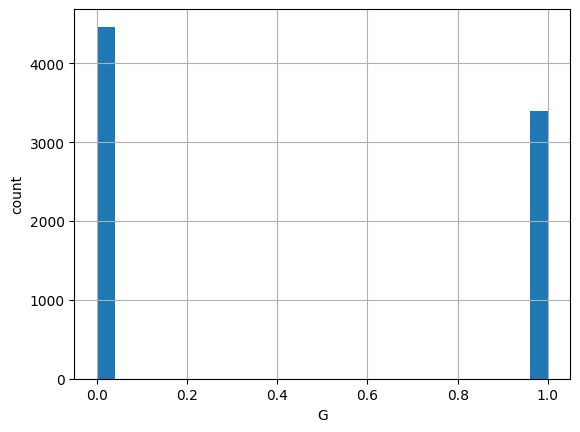

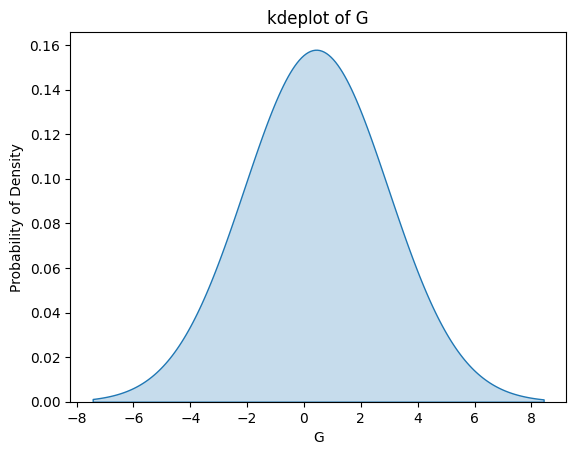

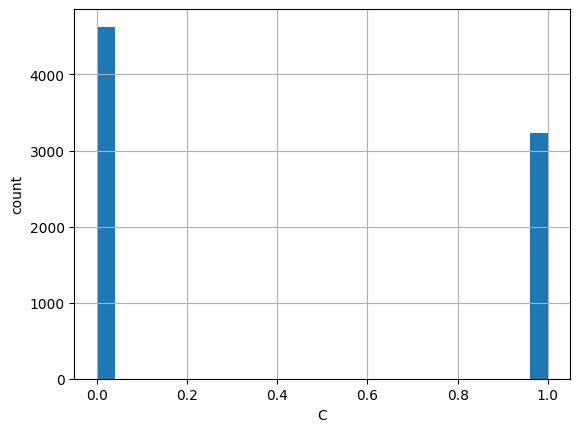

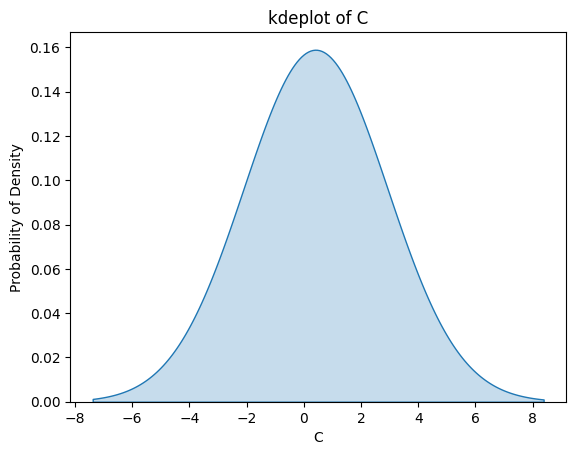

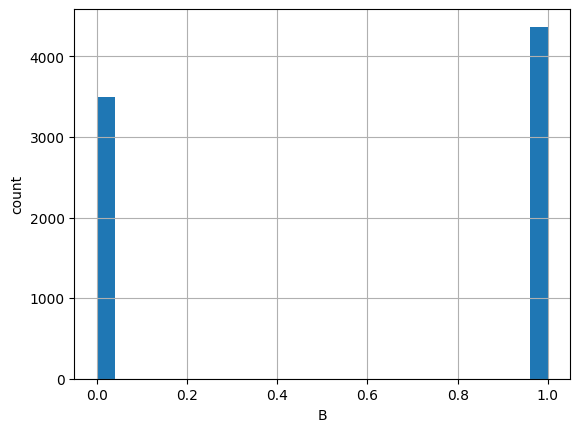

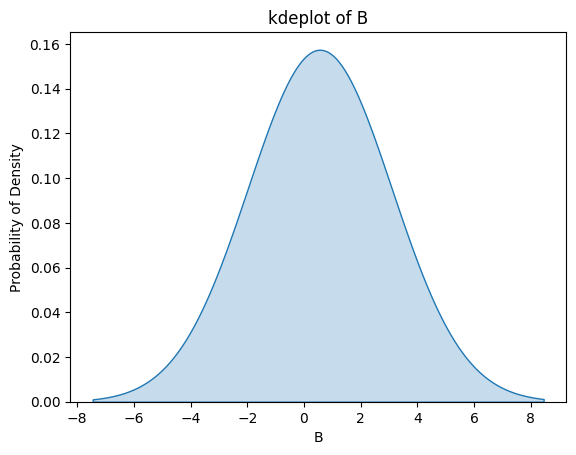

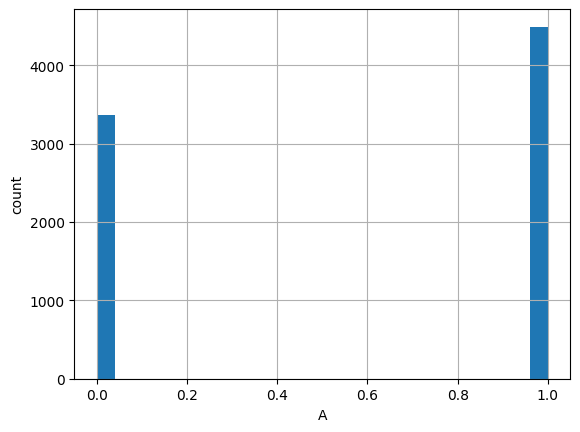

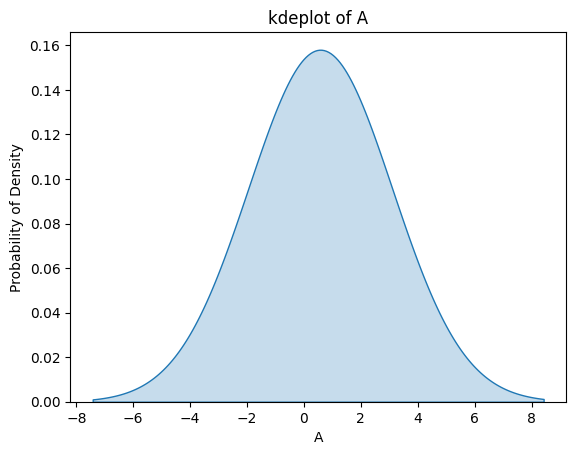

!!...End of Univariate Analysis of Discrete Variable ...!!
****************************************************************************************************
!!...Started Univariate Analysis of Continuous Variable ...!!


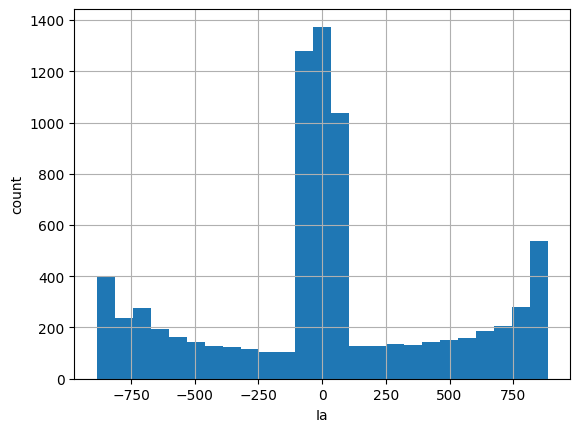

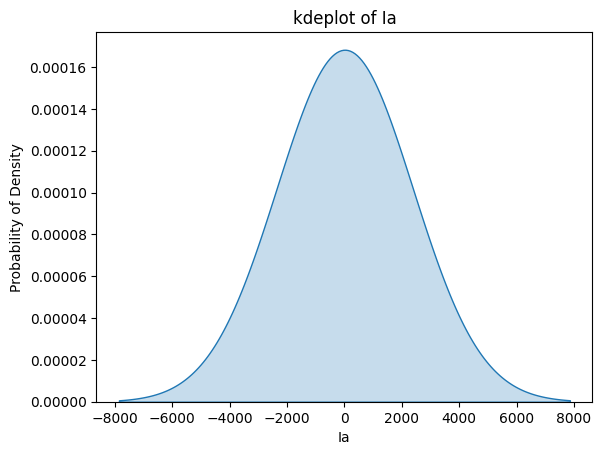

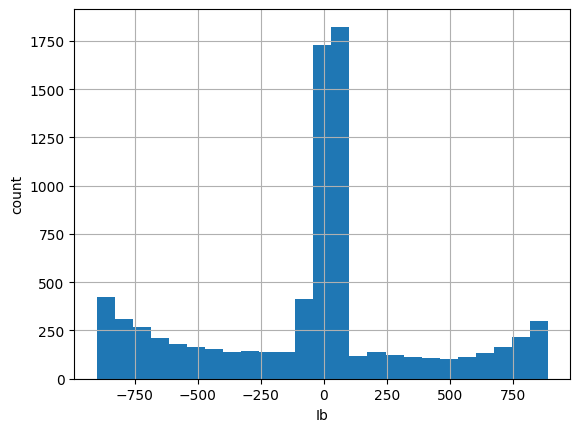

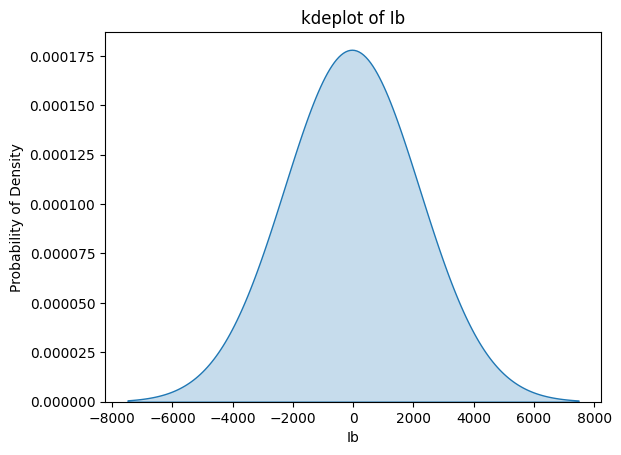

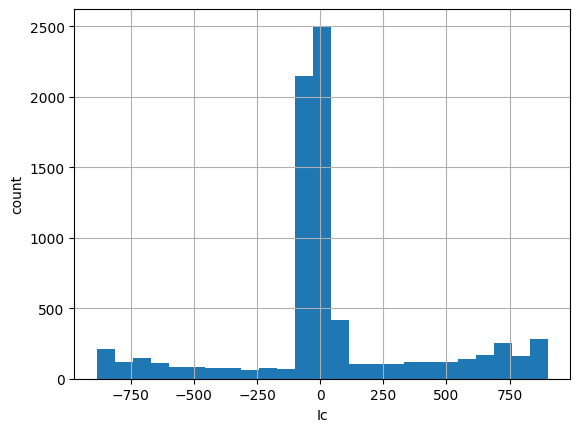

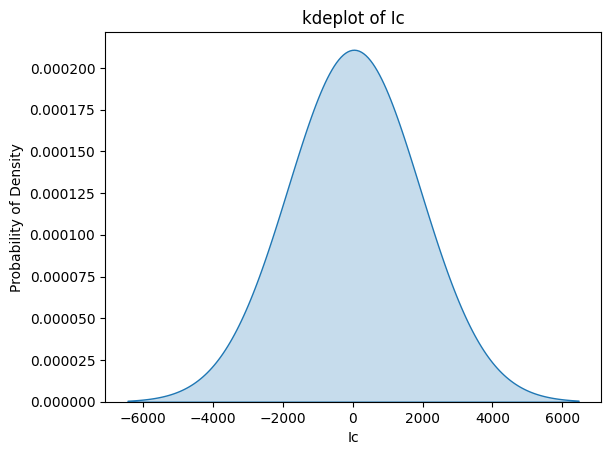

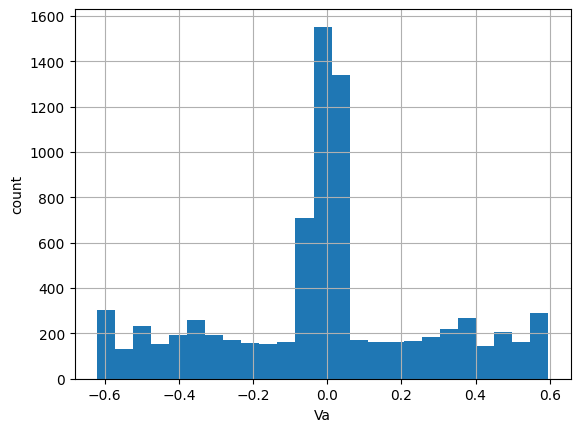

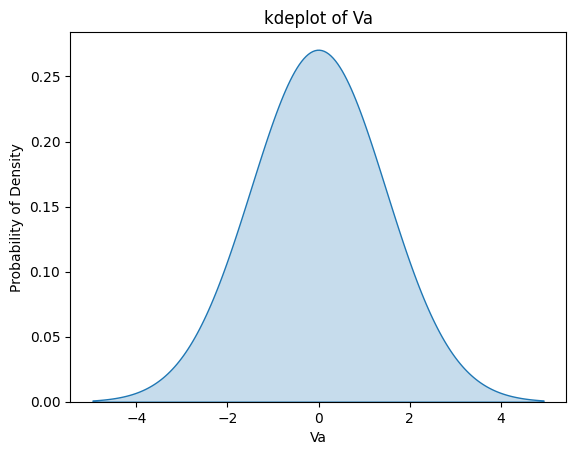

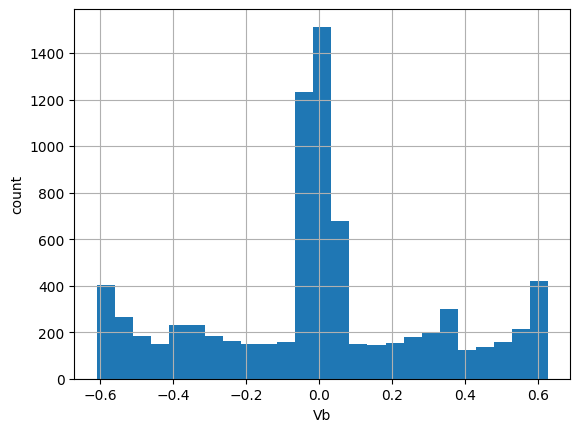

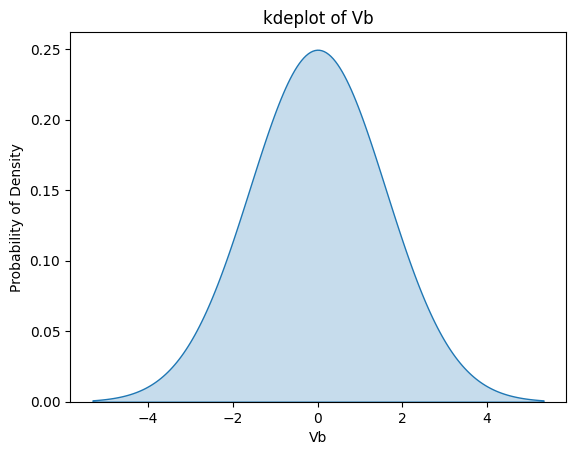

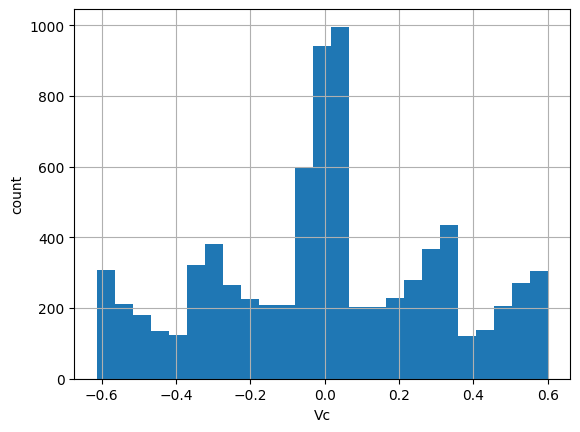

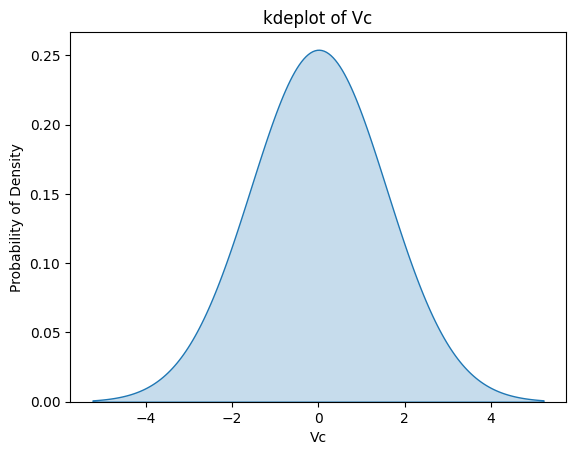

!!...End of Univariate Analysis of Continuous Variable ...!!
!!...Started Boxplot for Outliers Checking ...!!


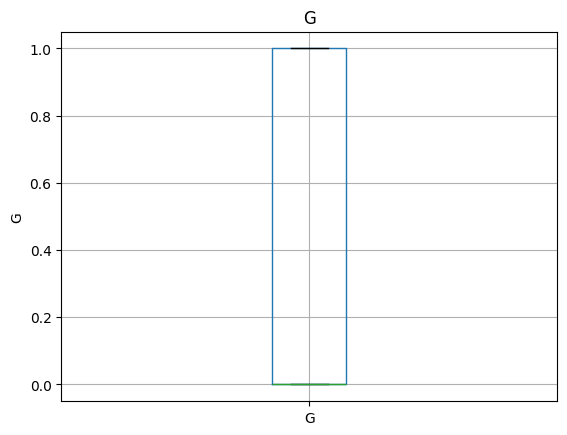

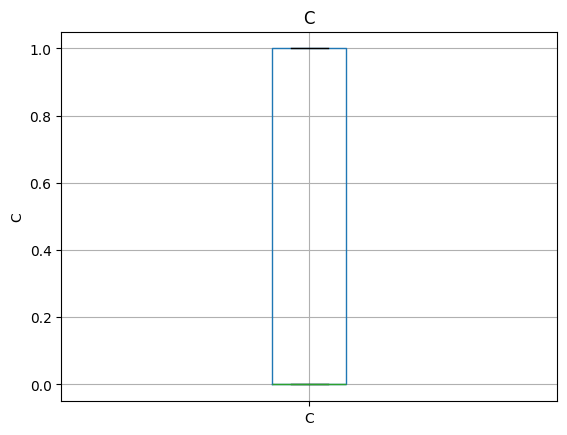

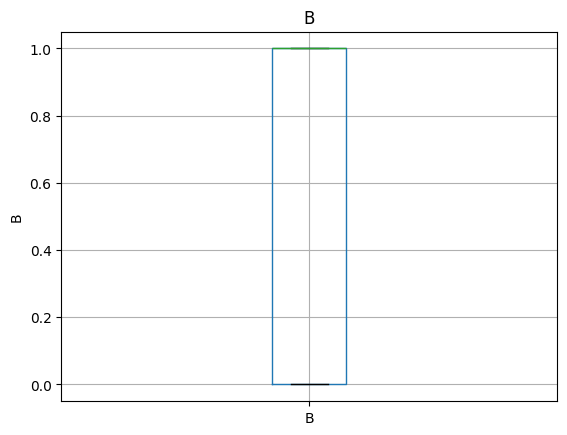

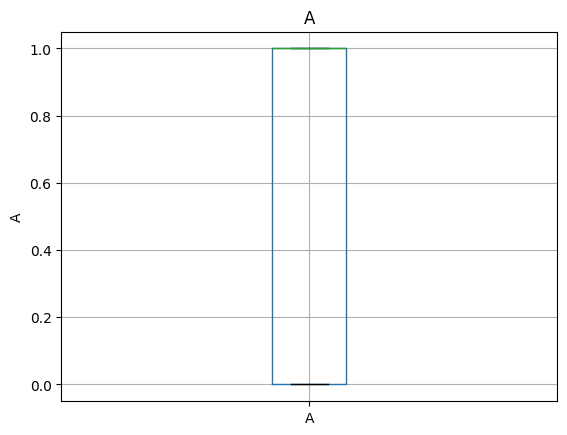

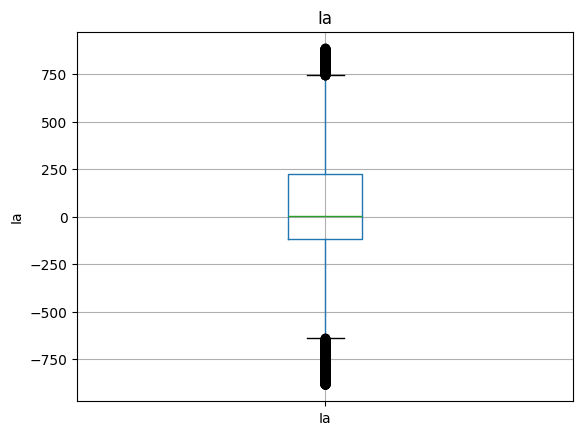

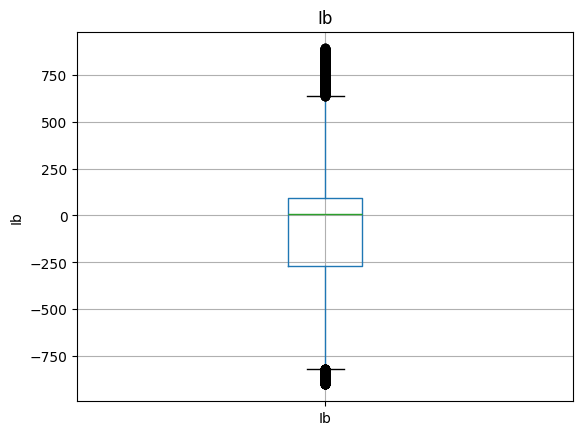

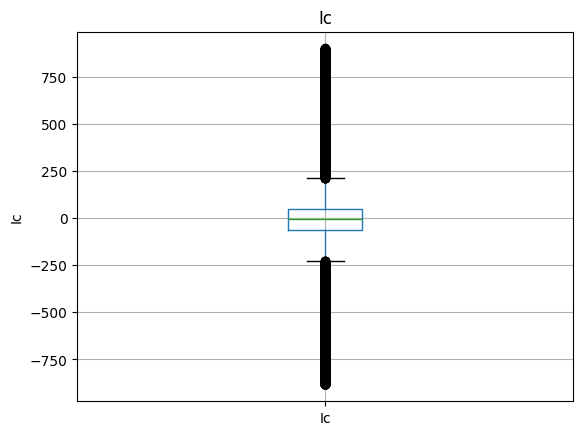

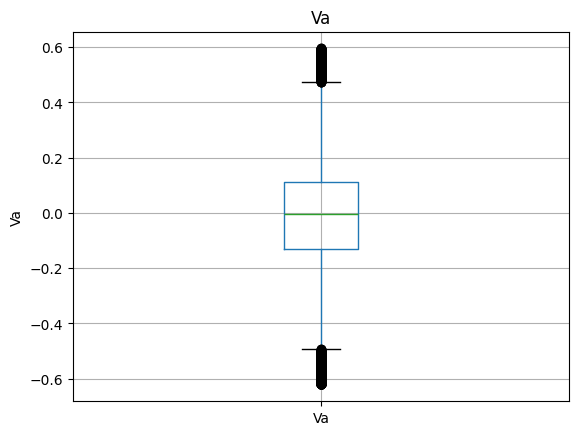

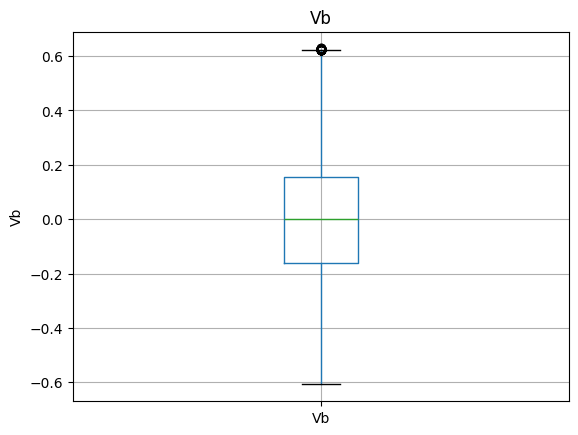

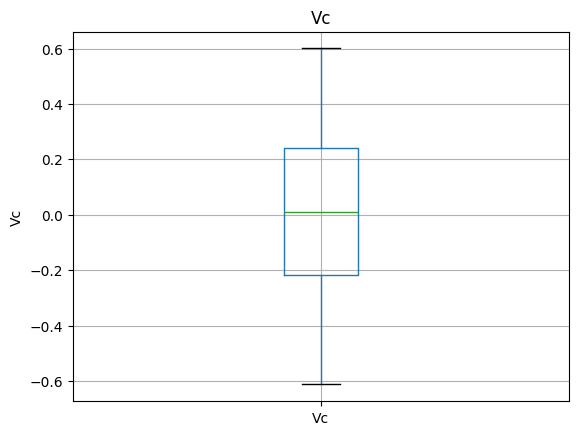

!!...End of Boxplot for Outliers Checking ...!!
!!...Summery of Outliers Checking ...!!
!!...Started Multivariate Analysis ...!!
           G         C         B         A        Ia        Ib        Ic        Va        Vb        Vc
G   1.000000 -0.137611  0.196609  0.755273  0.041310 -0.031068 -0.003156  0.023808 -0.024048  0.002122
C  -0.137611  1.000000  0.747612  0.199335  0.000232 -0.109211  0.164323  0.018188 -0.068840  0.052998
B   0.196609  0.747612  1.000000  0.448807  0.014102 -0.139981  0.133321  0.037128 -0.075973  0.042473
A   0.755273  0.199335  0.448807  1.000000  0.036341 -0.074905  0.054071  0.029940 -0.053036  0.025873
Ia  0.041310  0.000232  0.014102  0.036341  1.000000 -0.374241 -0.276457  0.035682 -0.274612  0.246043
Ib -0.031068 -0.109211 -0.139981 -0.074905 -0.374241  1.000000 -0.528291  0.029118  0.032101 -0.060023
Ic -0.003156  0.164323  0.133321  0.054071 -0.276457 -0.528291  1.000000 -0.069137 -0.056967  0.122919
Va  0.023808  0.018188  0.037128  0.029940  0.0

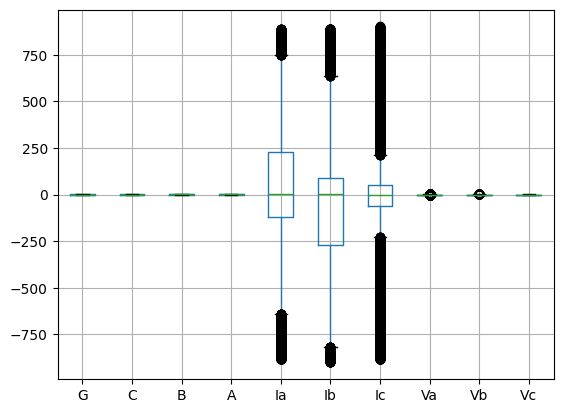

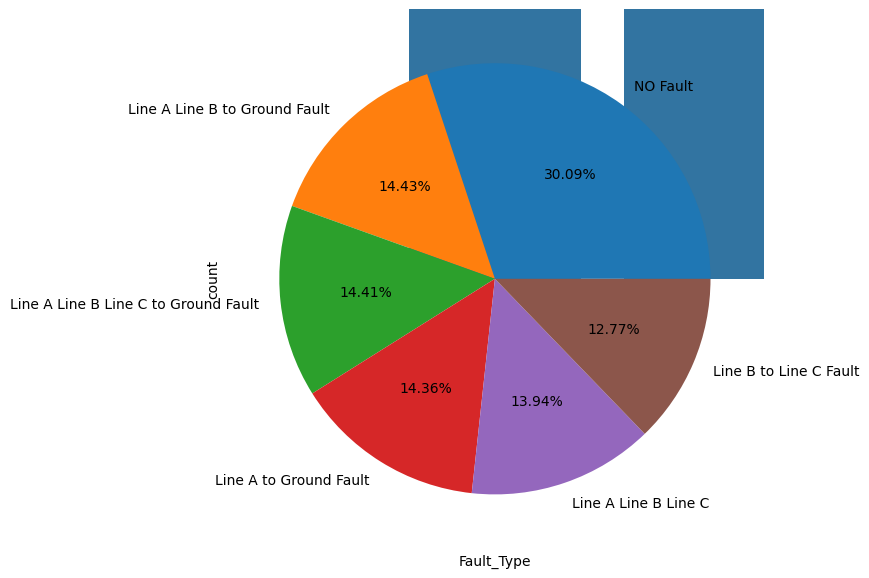

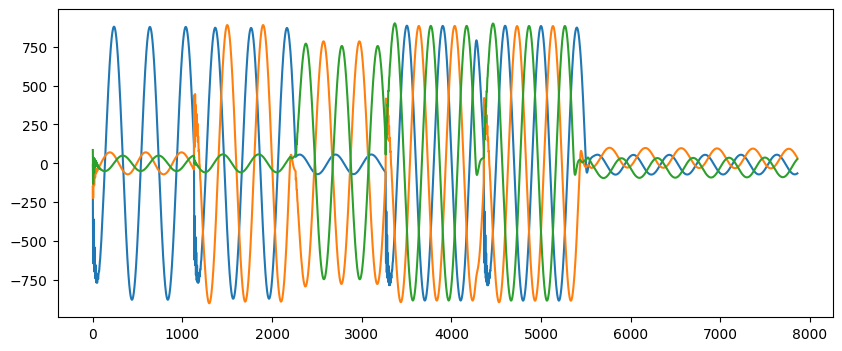

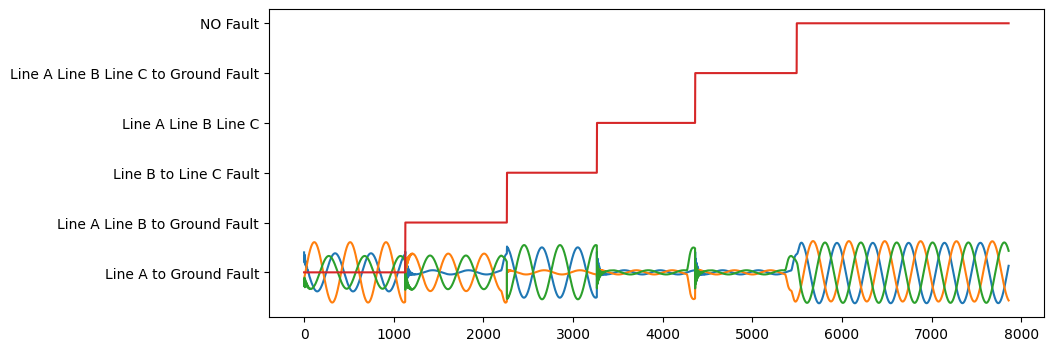

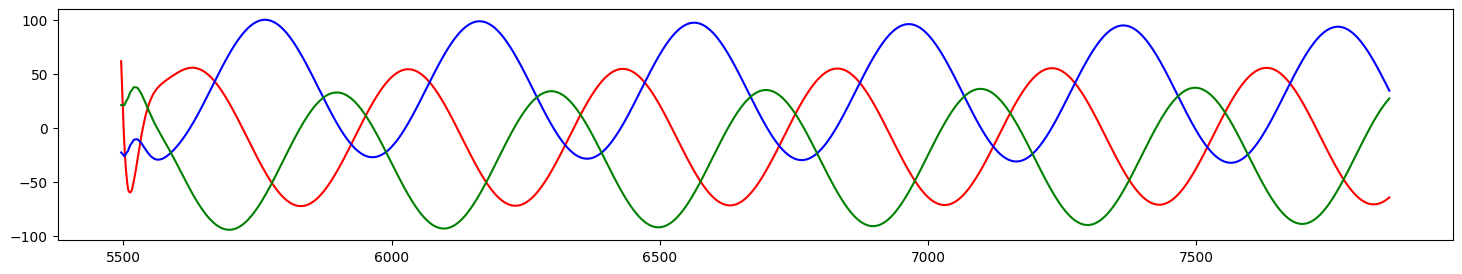

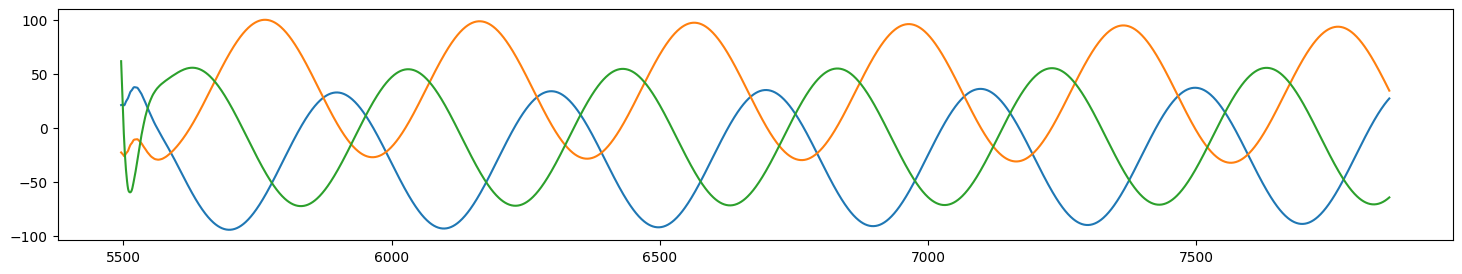

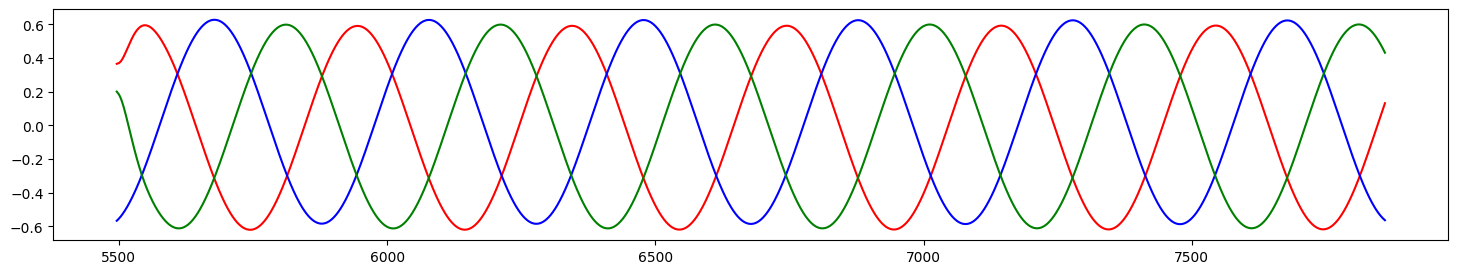

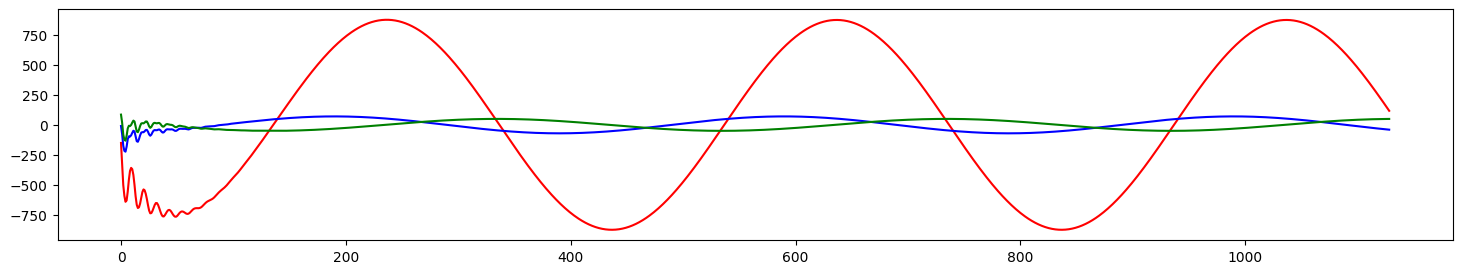

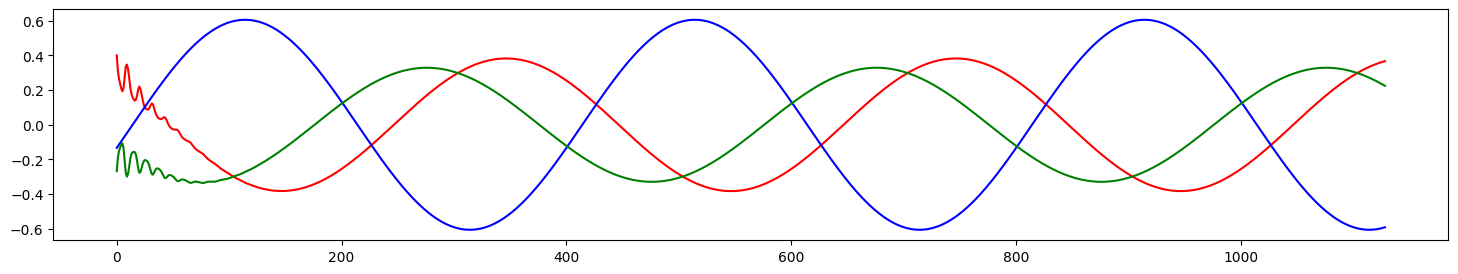

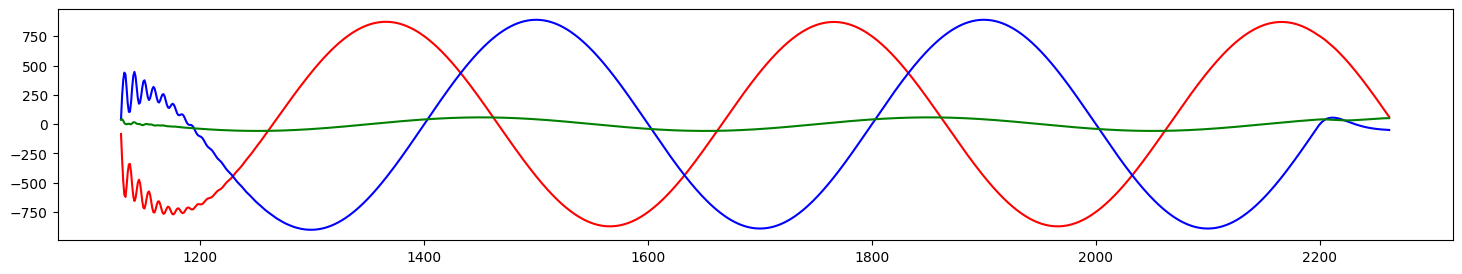

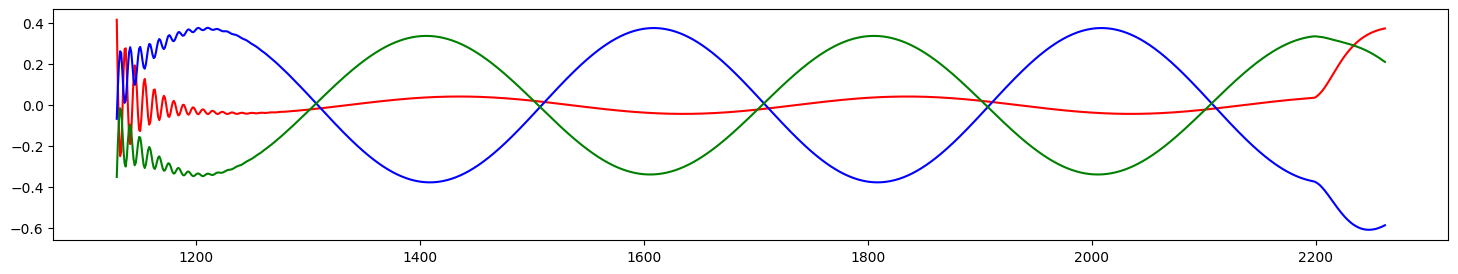

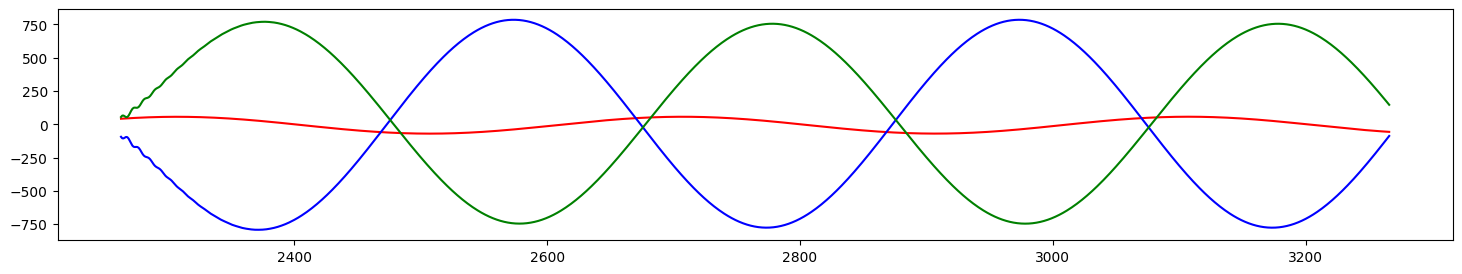

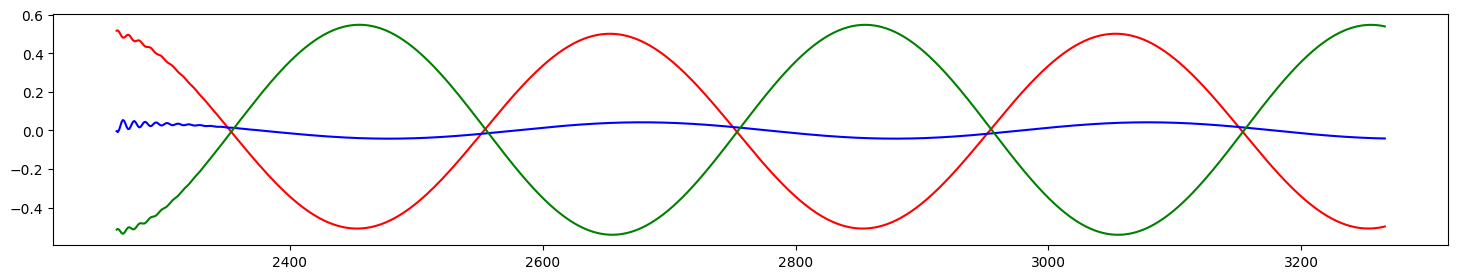

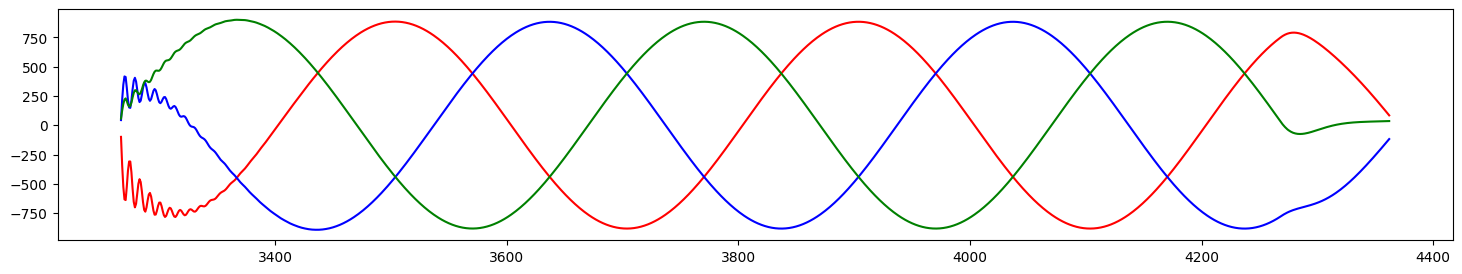

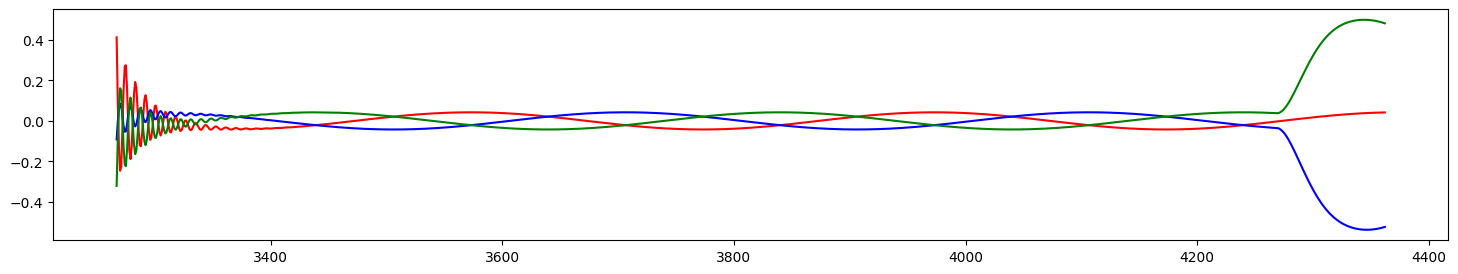

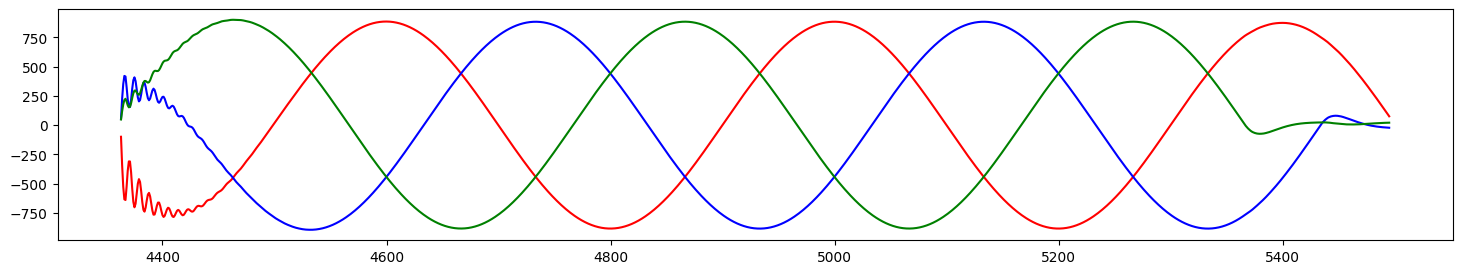

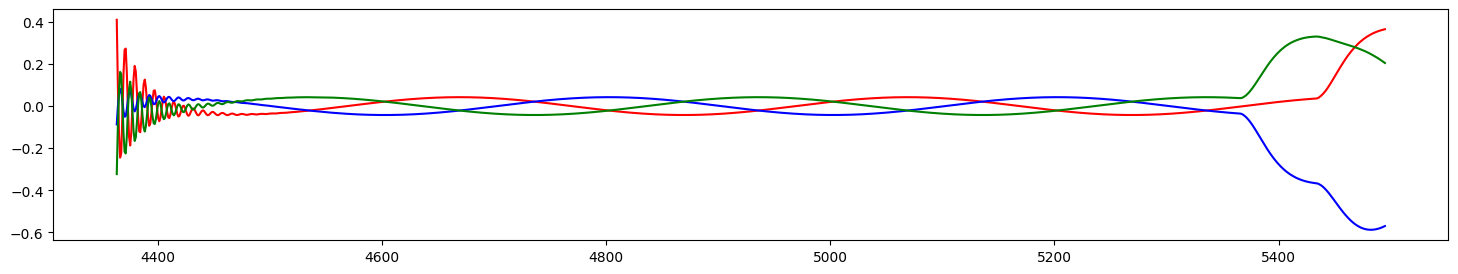

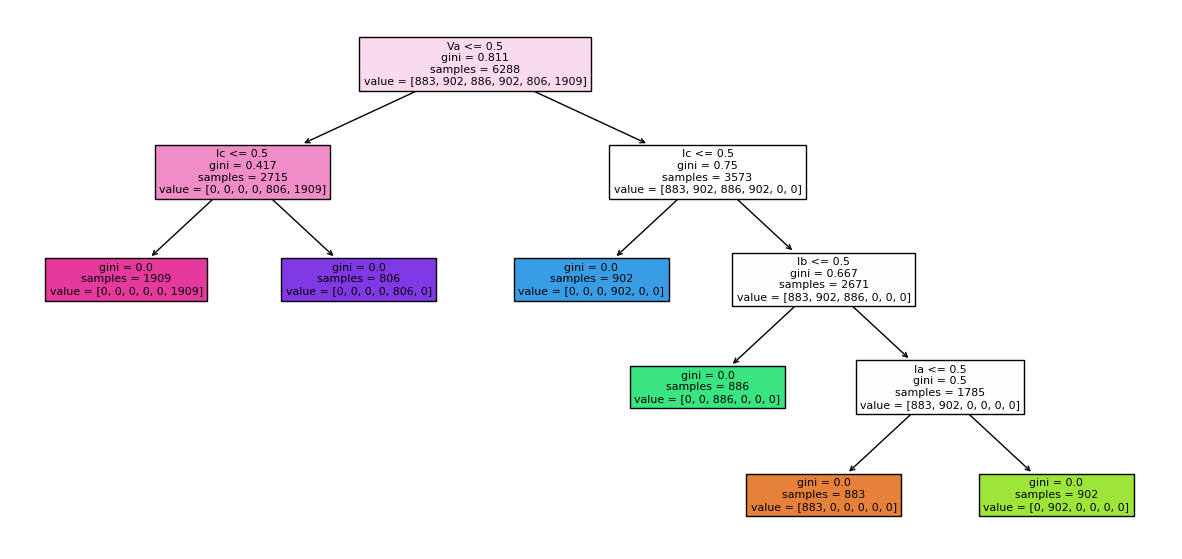

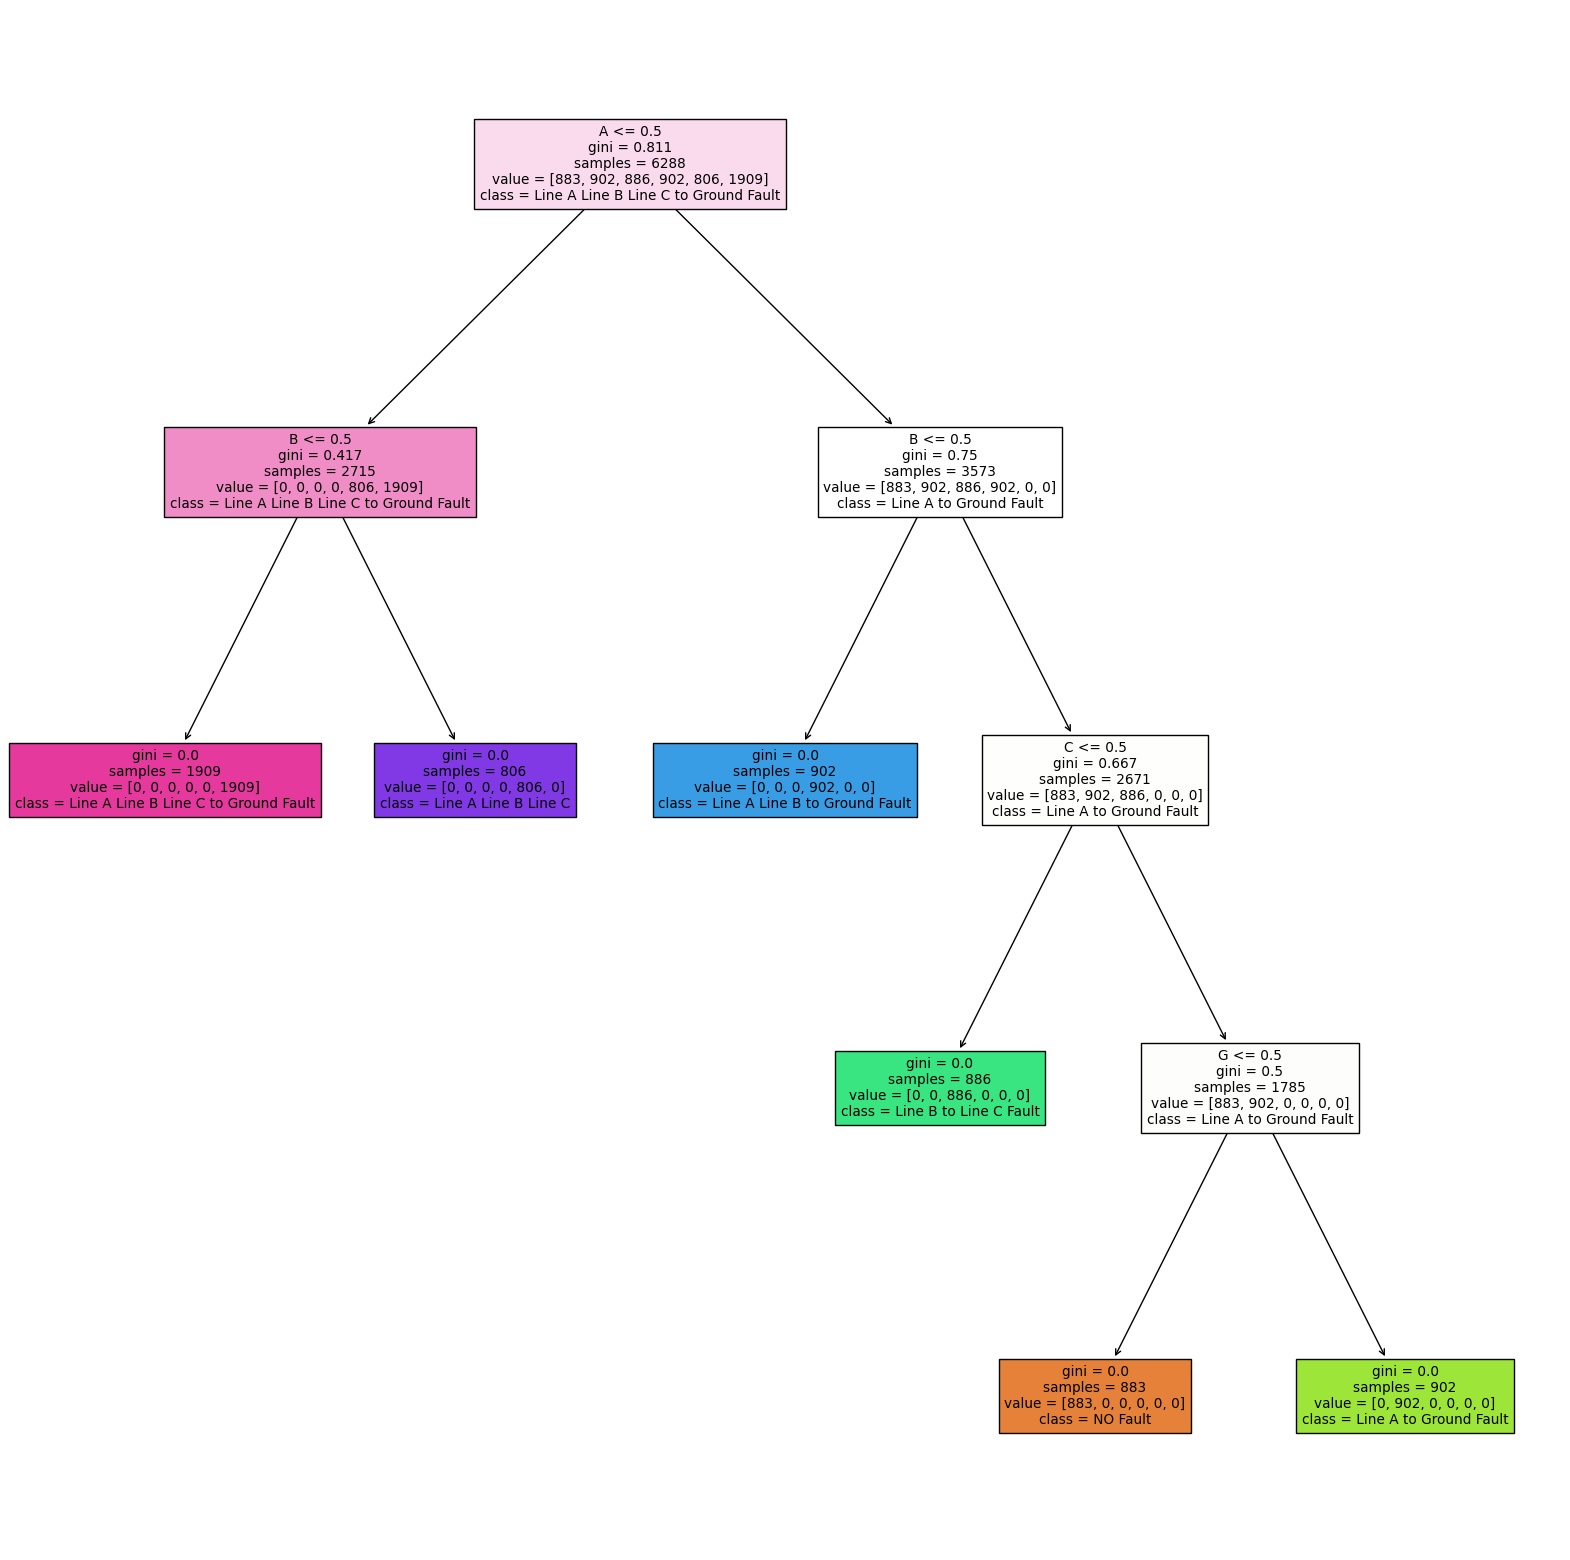

Training Accuracy of Random Forest Classifier   : 100.0 %
Model Accuracy Score of Random Forest Classifier : 100.0 %
--------------------------------------------------------
Classification_Report of Random Forest Classifier : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       1.00      1.00      1.00       231
           2       1.00      1.00      1.00       248
           3       1.00      1.00      1.00       227
           4       1.00      1.00      1.00       198
           5       1.00      1.00      1.00       456

    accuracy                           1.00      1573
   macro avg       1.00      1.00      1.00      1573
weighted avg       1.00      1.00      1.00      1573

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Training Accuracy of XGB Classifier    : 100.0 %
Model Accuracy Score of XGB Classifier : 100.0 %
--------------------------------------------------------
Classification

In [3]:
obj = Electric_Fault_Prediction()
obj.run()